In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.data.metrics import get_metrics

In [2]:
df = pd.read_json("../reports/discretization_grid_tune.jsonl", lines=True)
get_metrics(df, ['top_1_accuracy', "top_5_accuracy", 'macro_f1'])

In [3]:
hparams = ["model_cls", "loc_levels", "grow_factor", "discretization_rows", 'discretization_shape', 'embedding_type', 'embedding_weight_factor']
metrics = [
    "macro_f1",
    "top_5_accuracy",
    "top_1_accuracy",
]

In [12]:
def make_discretization_row_plot(
    df, model, metric, df_base=None, ax=None, figsize=(6, 3)
):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize, sharex=True, sharey=True)
    if df_base is not None: 
        df = pd.concat([df, df_base[df_base['loc_levels'] == 1]])
    df_agg = (
        df.groupby(["discretization_rows", "loc_levels", "model_cls"])[metric]
        .agg(["mean", "std"])
        .reset_index()
    )
    df_model = df_agg[df_agg["model_cls"] == model]

    # Generate colors from the viridis colormap
    cmap = plt.get_cmap("viridis", 4)
    colors = cmap(range(4))

    x = np.arange(100, 501, 100)
    df_base = df_model[df_model['loc_levels'] == 1]
    y = df_base["mean"].item()
    err = df_base["std"]
    color = colors[0]
    ax.plot(x, np.ones_like(x) * y, color=color, label=1)
    ax.fill_between(x, y - err, y + err, alpha=0.2, color=color)

    for loc_level in range(2, 5):
        df_line = df_model[df_model["loc_levels"] == loc_level]
        x = df_line["discretization_rows"]
        y = df_line["mean"]
        err = df_line["std"]
        color = colors[loc_level - 1]
        ax.plot(x, y, label=loc_level, color=color)
        ax.fill_between(x, y - err, y + err, alpha=0.2, color=color)
    ax.set_xlim(100, 500)
    return ax

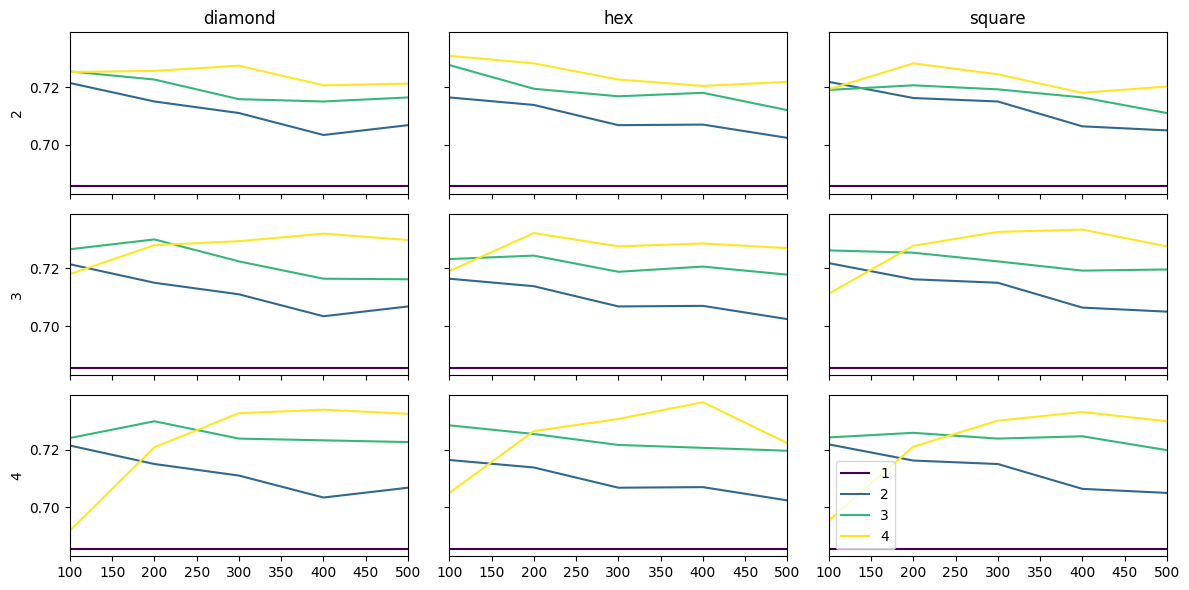

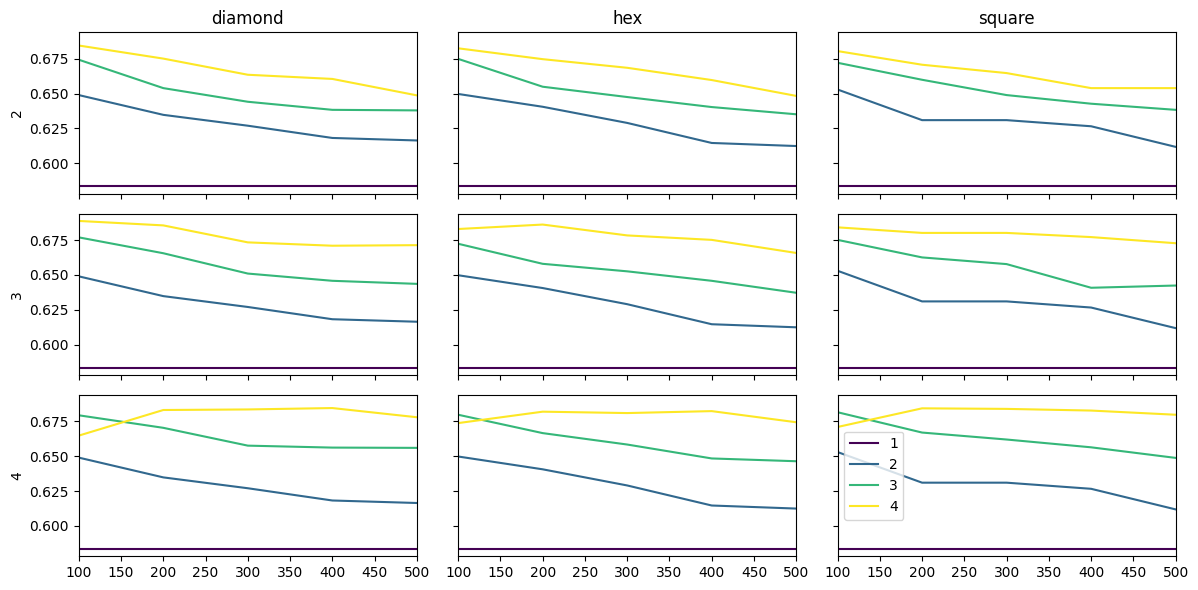

In [79]:
# Plot discretization shape + aggregation growth for BiTULER
metric = 'top_5_accuracy'
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 6), sharex=True, sharey=True)
df_plot = df[df["aggregation_mode"] == "grow"]
for col_idx, (shape, df_col) in enumerate(df_plot.groupby("discretization_shape")):
    axs[0, col_idx].set_title(shape)
    for row_idx, (grow_factor, df_row) in enumerate(df_col.groupby("grow_factor")):
        ax = axs[row_idx, col_idx]
        make_discretization_row_plot(df_row, df_base=df, model='BiTULER', ax=ax, metric=metric)
        if col_idx == 0:
            ax.set_ylabel(grow_factor)
leg = ax.legend()
fig.tight_layout()

# Plot discretization shape + aggregation growth for BiTULER
metric = 'top_5_accuracy'
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 6), sharex=True, sharey=True)
df_plot = df[df["aggregation_mode"] == "grow"]
for col_idx, (shape, df_col) in enumerate(df_plot.groupby("discretization_shape")):
    axs[0, col_idx].set_title(shape)
    for row_idx, (grow_factor, df_row) in enumerate(df_col.groupby("grow_factor")):
        ax = axs[row_idx, col_idx]
        make_discretization_row_plot(df_row, df_base=df, model='TULHOR', ax=ax, metric=metric)
        if col_idx == 0:
            ax.set_ylabel(grow_factor)
leg = ax.legend()
fig.tight_layout()

In [6]:
df["criterion"] = (
    2
    * df["top_1_accuracy"]
    * df["top_5_accuracy"]
    / (df["top_1_accuracy"] + df["top_5_accuracy"])
)
hparams = [
    'model_cls',
    "loc_levels",
    "grow_factor",
    "discretization_rows",
    "embedding_type",
    "embedding_weight_factor",
]

dfg = df[df["aggregation_mode"] == "grow"].reset_index()
df_mean = dfg.groupby(hparams)[metrics + ["criterion"]].mean().reset_index()
idcs_max = df_mean.groupby(["embedding_type", 'model_cls'])["criterion"].idxmax()

df_mean.loc[idcs_max][hparams + metrics + ["criterion"]]

,model_cls,loc_levels,grow_factor,discretization_rows,embedding_type,embedding_weight_factor,macro_f1,top_5_accuracy,top_1_accuracy,criterion
91,BiTULER,4,4,400,lookup_concat,2.0,0.524734,0.7066,0.5780,0.635863
196,TULHOR,4,4,500,lookup_concat,1.0,0.449183,0.6420,0.5044,0.564942
16,BiTULER,2,3,200,lookup_sum,1.0,0.495842,0.6858,0.5536,0.612649
103,TULHOR,2,2,100,lookup_sum,1.0,0.394347,0.5778,0.4472,0.504180


In [9]:
df = pd.read_json("/home/cazzonelli/Documents/trajectory-forecasting/reports/discretization_grid.jsonl", lines=True, orient='records')
get_metrics(df, metrics=["top_1_accuracy", "top_5_accuracy", "macro_f1"])

Text(0.5, 1.0, 'BiTULER')

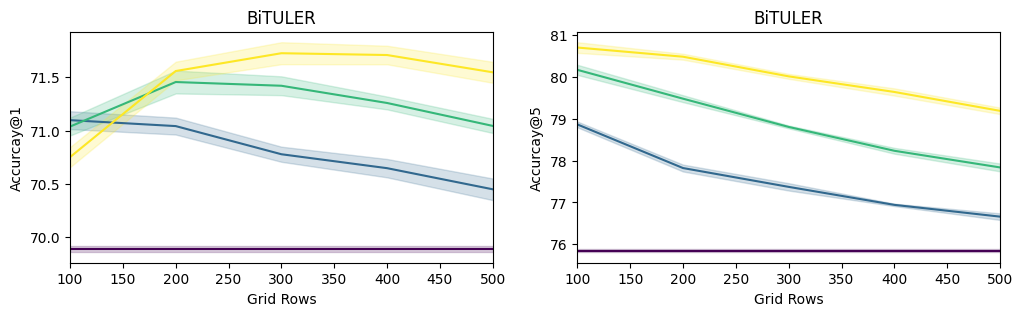

In [55]:
# Plot grouped discretization, weighted sum aggregation
df_plot = df[
    (df["embedding_type"] == "lookup_concat") & (df["aggregation_mode"] == "grow")
]
df_plot.loc[:, ["top_1_accuracy", 'top_5_accuracy']] *= 100
fig, axs = plt.subplots(ncols=2, figsize=(12, 3), sharex=True)
make_discretization_row_plot(
    df_plot, model="BiTULER", metric="top_1_accuracy", ax=axs[0]
)
make_discretization_row_plot(
    df_plot, model="BiTULER", metric="top_5_accuracy", ax=axs[1]
)
axs[0].set_ylabel("Accurcay@1")
axs[1].set_ylabel("Accurcay@5")
axs[0].set_xlabel("Grid Rows")
axs[1].set_xlabel("Grid Rows")
axs[0].set_title("BiTULER")
axs[1].set_title("BiTULER")

Text(0.5, 1.0, 'TULHOR')

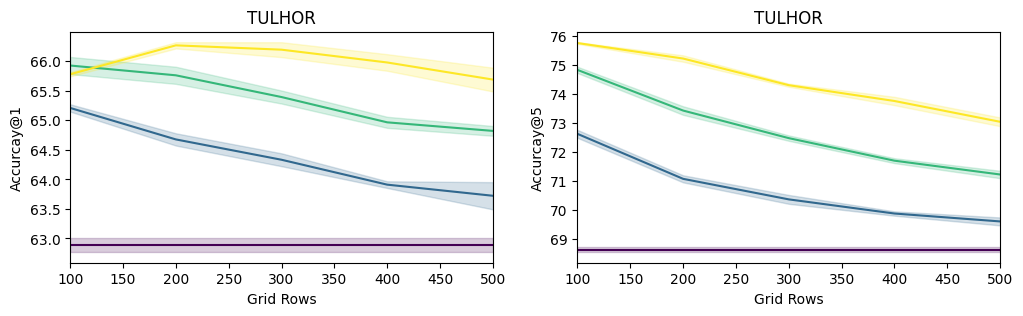

In [58]:
# Plot TULHOR Results
df_plot = df[
    (df["embedding_type"] == "lookup_concat") & (df["aggregation_mode"] == "grow")
]
df_plot.loc[:, ["top_1_accuracy", 'top_5_accuracy']] *= 100
fig, axs = plt.subplots(ncols=2, figsize=(12, 3), sharex=True)
make_discretization_row_plot(
    df_plot, model="TULHOR", metric="top_1_accuracy", ax=axs[0]
)
make_discretization_row_plot(
    df_plot, model="TULHOR", metric="top_5_accuracy", ax=axs[1]
)
axs[0].set_ylabel("Accurcay@1")
axs[1].set_ylabel("Accurcay@5")
axs[0].set_xlabel("Grid Rows")
axs[1].set_xlabel("Grid Rows")
axs[0].set_title("TULHOR")
axs[1].set_title("TULHOR")

Text(0.5, 1.0, 'Sum')

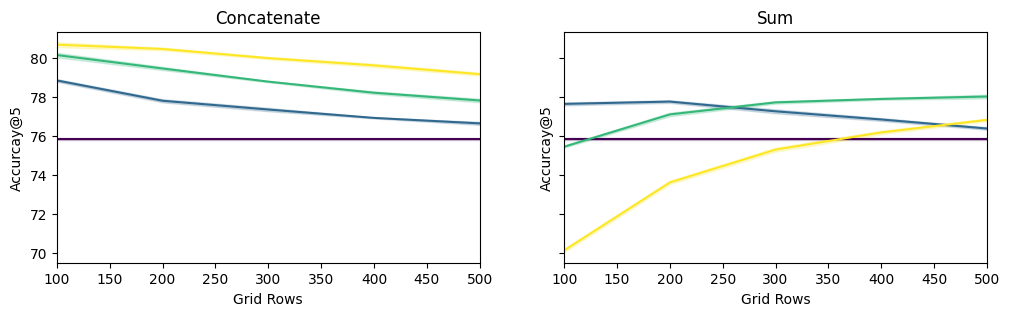

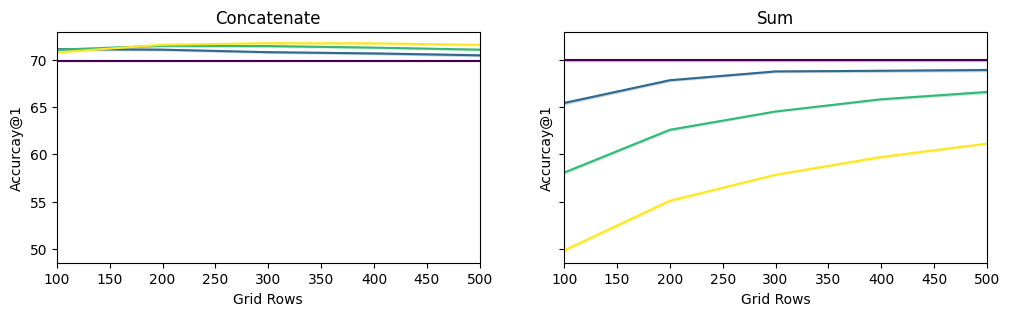

In [62]:
# Plot results for different embedding aggregation approaches
df_plot = df[(df["aggregation_mode"] == "grow")]
df_plot.loc[:, ["top_1_accuracy", "top_5_accuracy"]] *= 100

fig, axs = plt.subplots(ncols=2, figsize=(12, 3), sharex=True, sharey=True)
embedding_types = ["lookup_concat", "lookup_sum" ]
for ax, embedding_type in zip(axs, embedding_types):
    df_type = df_plot[df_plot["embedding_type"] == embedding_type]
    make_discretization_row_plot(
        df_type,
        model="BiTULER",
        metric="top_5_accuracy",
        ax=ax,
    )
    ax.set_ylabel("Accurcay@5")
    ax.set_xlabel("Grid Rows")

axs[0].set_title("Concatenate")
axs[1].set_title("Sum")

df_plot = df[(df["aggregation_mode"] == "grow")]
df_plot.loc[:, ["top_1_accuracy", "top_5_accuracy"]] *= 100

fig, axs = plt.subplots(ncols=2, figsize=(12, 3), sharex=True, sharey=True)
embedding_types = ["lookup_concat", "lookup_sum"]
for ax, embedding_type in zip(axs, embedding_types):
    df_type = df_plot[df_plot["embedding_type"] == embedding_type]
    make_discretization_row_plot(
        df_type,
        model="BiTULER",
        metric="top_1_accuracy",
        ax=ax,
    )
    ax.set_ylabel("Accurcay@1")
    ax.set_xlabel("Grid Rows")

axs[0].set_title("Concatenate")
axs[1].set_title("Sum")

